In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import glob

## Read files and keep only Israel

In [ ]:
file_paths = glob.glob("~/path/places-*.zstd.parquet")
country_code = 'IL'
dataframes = []

for file in file_paths:

    df_part = pd.read_parquet(file)

    if len(df_part.query(f"country == {country_code}")) > 0:

        dfc = df_part.query(f"country == {country_code}")

        dataframes.append(dfc)

df = pd.concat(dataframes)

In [11]:
df.shape

(132980, 28)

In [12]:
df.columns

Index(['index', 'fsq_place_id', 'name', 'latitude', 'longitude', 'address',
       'locality', 'region', 'postcode', 'admin_region', 'post_town', 'po_box',
       'country', 'date_created', 'date_refreshed', 'date_closed', 'tel',
       'website', 'email', 'facebook_id', 'instagram', 'twitter',
       'fsq_category_ids', 'fsq_category_labels', 'placemaker_url', 'bbox',
       'geometry', 'the_geom'],
      dtype='object')

#### Share of unique IDs

In [ ]:
df["fsq_place_id"].nunique() / df.shape[0]

0.8104151000150398

In [ ]:
df["fsq_place_id"].value_counts().head()

50ee8287e4b04a76a4e975af    9
531e6ed2097d4cd7c5df06ad    9
517f64b2e4b0ea9c7185f563    9
5d552dc32d6ab9000867bc54    9
4b58c249f964a5208c6928e3    9
Name: fsq_place_id, dtype: int64

# Test duplicates for one id

In [ ]:
test_id = "50ee8287e4b04a76a4e975af"

In [ ]:
df[df["fsq_place_id"] == test_id].shape

(9, 28)

In [ ]:
df[df["fsq_place_id"] == test_id].explore(color="red")

In [ ]:
df[df["fsq_place_id"] == test_id]["fsq_category_labels"].value_counts()

Landmarks and Outdoors > Historic and Protected Site    3
Community and Government > Spiritual Center             3
Arts and Entertainment > Museum > History Museum        3
Name: fsq_category_labels, dtype: int64

In [ ]:
df[df["fsq_place_id"] == test_id]["placemaker_url"].drop_duplicates()

65073    https://foursquare.com/placemakers/review-plac...
Name: placemaker_url, dtype: object

#### Number of unique values for each columns

In [ ]:
df[df["fsq_place_id"] == test_id].drop(
    ["bbox", "geometry", "the_geom"], axis=1
).nunique().to_frame().T

,index,fsq_place_id,name,latitude,longitude,address,locality,region,postcode,admin_region,...,tel,website,email,facebook_id,instagram,twitter,fsq_category_ids,fsq_category_labels,placemaker_url,empty_fields_share
0,1,1,1,1,1,1,1,0,1,0,...,1,1,1,1,0,1,3,3,1,1


#### Check if the same id was created or updated at the same time

In [ ]:
df[df["fsq_place_id"] == test_id][["date_created", "date_refreshed"]].drop_duplicates()

,date_created,date_refreshed
65073,2013-01-10,2014-07-10


#### Check if the same id have different ratio of filled values

In [40]:
df["empty_fields_share"] = df.isnull().mean(axis=1)

In [ ]:
df[df["fsq_place_id"] == test_id]["empty_fields_share"].unique()

array([0.25])

#### Check if the same id can refer to two different locations

In [ ]:
df[df["fsq_place_id"] == test_id][["latitude", "longitude"]].drop_duplicates()

,latitude,longitude
65073,32.28098,34.861001


## Check if all this works for each ID in the dataset

In [ ]:
df.groupby(["fsq_place_id", "date_created", "date_refreshed"]).size().groupby(
    "fsq_place_id"
).size().describe()

count    107766.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

#### Check if the same id can refer to two different locations

In [ ]:
df.groupby(["fsq_place_id", "latitude", "longitude"]).size().groupby(
    "fsq_place_id"
).size().describe()

count    107729.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

#### Check if the same id have different ratio of filled values

In [ ]:
df.groupby(["fsq_place_id", "empty_fields_share"]).size().groupby(
    "fsq_place_id"
).size().describe()

count    107769.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
dtype: float64

### Remove duplicates

In [ ]:
df = df.drop_duplicates(["fsq_place_id"])

### Records with old refresh date

In [ ]:
from datetime import datetime


df["days_from_refresh"] = (
    datetime.today() - pd.to_datetime(df["date_refreshed"])
).dt.days
df["month_from_refresh"] = (
    datetime.today() - pd.to_datetime(df["date_refreshed"])
).dt.days // 30

In [ ]:
(df["month_from_refresh"] > 12 * 10).mean()

0.32023123532741327

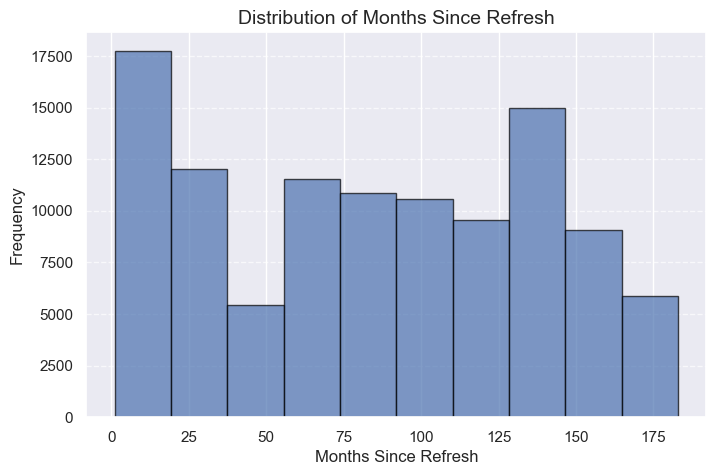

In [ ]:
# Plotting the histogram with English labels
from matplotlib import pyplot as plt


plt.figure(figsize=(8, 5))
plt.hist(df["month_from_refresh"], bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Months Since Refresh", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Months Since Refresh", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Check and remove ids with empty key features

In [ ]:
columns_important = [
    "fsq_place_id",
    "latitude",
    "longitude",
    "geometry",
    "fsq_category_ids",
    "date_created",
]
df[columns_important].isnull().mean()

fsq_place_id        0.000000
latitude            0.000371
longitude           0.000371
geometry            0.000371
fsq_category_ids    0.079392
date_created        0.000000
dtype: float64

In [ ]:
df[df[columns_important].isnull().sum(axis=1) > 0][columns_important].shape[
    0
] / df.shape[0]

0.07947554491551374

In [ ]:
df = df[df[columns_important].isnull().sum(axis=1) == 0]

## Distribution of the empty fields share

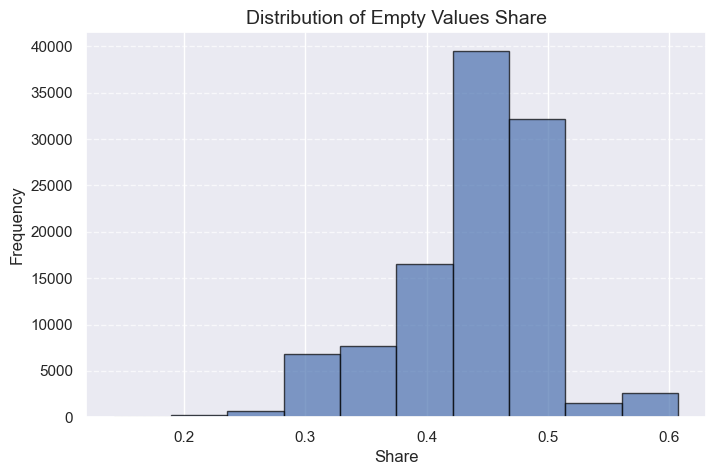

In [ ]:
# Plotting the histogram with English labels
from matplotlib import pyplot as plt


plt.figure(figsize=(8, 5))
plt.hist(df["empty_fields_share"], bins=10, edgecolor="black", alpha=0.7)
plt.xlabel("Share", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Empty Values Share", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Calculate confidence interval

Instead of removing records with the high share of emtpy values or potentially outdate records, we add confidence interval

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Apply RobustScaler (reshape needed for single column)
df["days_from_refresh_scaled"] = scaler.fit_transform(df[["days_from_refresh"]])
df["empty_fields_share_scaled"] = scaler.fit_transform(df[["empty_fields_share"]])

In [ ]:
np.sqrt(df["empty_fields_share_scaled"]).describe()

count    107769.000000
mean          0.794916
std           0.090887
min           0.000000
25%           0.733799
50%           0.784465
75%           0.877058
max           1.000000
Name: empty_fields_share_scaled, dtype: float64

In [ ]:
df["confidence"] = 0.5 * np.sqrt((1 - df["empty_fields_share_scaled"])) + 0.5 * np.sqrt(
    (1 - df["days_from_refresh_scaled"])
)

In [ ]:
df["confidence"].describe()

count    107766.000000
mean          0.646567
std           0.133679
min           0.138675
25%           0.548706
50%           0.656013
75%           0.751126
max           0.998307
Name: confidence, dtype: float64

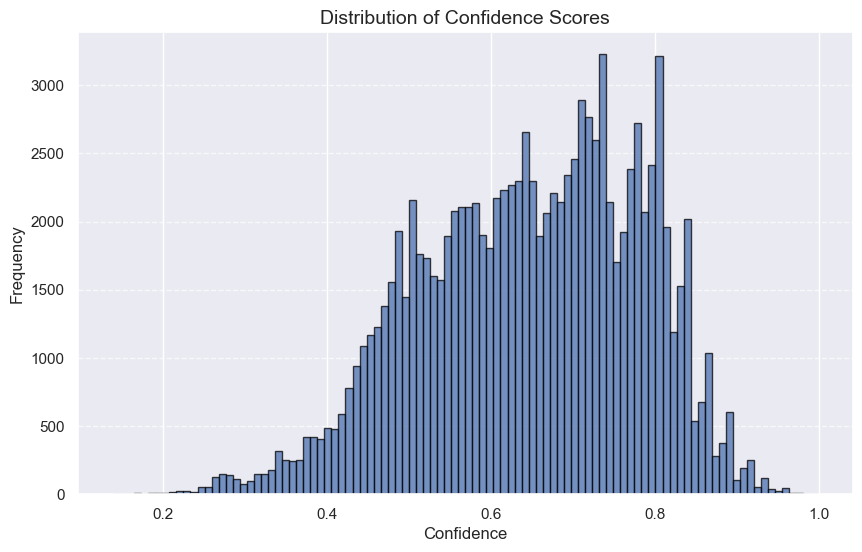

In [ ]:
# Plotting a refined histogram for 'confidence'
plt.figure(figsize=(10, 6))
plt.hist(df["confidence"], bins=100, edgecolor="black", alpha=0.75)
plt.xlabel("Confidence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Confidence Scores", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

## Add categories dataset

In [ ]:
import pandas as pd

frsq_categories = pd.read_parquet(
    "categories.zstd.parquet"
)
ta_frsq_gdf = df.merge(
    frsq_categories, left_on="fsq_category_ids", right_on="category_id", how="left"
)

In [16]:
ta_frsq_gdf.columns

Index(['index', 'fsq_place_id', 'name', 'latitude', 'longitude', 'address',
       'locality', 'region', 'postcode', 'admin_region', 'post_town', 'po_box',
       'country', 'date_created', 'date_refreshed', 'date_closed', 'tel',
       'website', 'email', 'facebook_id', 'instagram', 'twitter',
       'fsq_category_ids', 'fsq_category_labels', 'placemaker_url', 'bbox',
       'geometry', 'the_geom', 'category_id', 'category_level',
       'category_name', 'category_label', 'level1_category_id',
       'level1_category_name', 'level2_category_id', 'level2_category_name',
       'level3_category_id', 'level3_category_name', 'level4_category_id',
       'level4_category_name', 'level5_category_id', 'level5_category_name',
       'level6_category_id', 'level6_category_name'],
      dtype='object')

In [ ]:
ta_frsq_gdf.to_file("../frsq_places_cleaned.geojson")